In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype  # for specifying levels in categoricals
from datetime import datetime  # for datetime parsing
import re  # for string substitution
import json
from sksurv.preprocessing import OneHotEncoder
from rxnorm_query import query_findRxcuiByString
from util import resolve_path

In [29]:
FILEPATH_MEDICATION='H:/Documents/NCATS/GBM/clinicalData/Updated_All_Med_Data_for_MIS_and_CRIS_sent_to_Zhu_1-18-2023.xlsx - MIS+CRIS_Meds.csv'


In [30]:
def preprocess_meds_df(filepath: str=FILEPATH_MEDICATION) -> pd.DataFrame:
    '''Does not exit pipe.'''

    print('Preprocessing data...')

    # Specify categorical columns' levels
    drug_type_type = CategoricalDtype(categories=['Formulary', 'Non Formulary'])
    order_status_type = CategoricalDtype(categories=['GIV'])
    take_home_flag_type = CategoricalDtype(categories=['1', '0'])
    admin_status_type = CategoricalDtype(categories=['Performed'])

    # Define the desired column types (note: column names will be de-spaced in `despace_col_names()`)
    column_types = {
        # `Row No` = 'Int64',
        'Subject': 'str',
        # `Data Type` = 'str',
        'Order_Name': 'str',
        'drug_type': drug_type_type,
        'drug_ingredients': 'str',
        'Category': 'str',
        'top_therapeutic_category': 'category',  # inferred
        'therapeutic_category': 'category',  # inferred
        'Order_Note': 'str',
        'Event_Primary_Date_Time': 'str',  # to be parsed
        'Order Status': order_status_type,
        'Take_Home_Flag': take_home_flag_type,
        'Order Frequency': 'str',
        'Order Dose': 'str',
        'Order  Route': 'str',
        # `Admin Route` = 'str',
        'Admin Status': admin_status_type,
        'Admin Performed Dt': 'str',  # to be parsed
        # 'Med_Name_w_Dose': 'str',
        # 'Order Summary': 'str'
        # `Admin Date` = 'str'  # could be parsed
    }

    # Select desired columns
    selected_columns = list(column_types.keys())

    # Specify file-wide NA values
    na_values = ['', 'NULL']

    # Import Data
    df = pd.read_csv(filepath, usecols=selected_columns,
                    dtype=column_types, na_values=na_values)

    '''Parse date(time)s'''
    date_formats = ['%m/%d/%y %I:%M %p', '%m/%d/%y %H:%M']
    def custom_date_parser(date_str: str):
        # Check if `data_str` is NaN ('nan' because it was imported as a string)
        if date_str == 'nan':
            return None
        # Try parsing the string in each format
        for fmt in date_formats:
            try:
                return datetime.strptime(str(date_str), fmt)
            except ValueError:
                pass
        # Raise an error if none of the formats match
        raise ValueError(f'No matching format for {date_str}')
    # Parse using above function
    df['Event_Primary_Date_Time'] = pd.to_datetime(df['Event_Primary_Date_Time'], format=date_formats[0])
    df['Admin Performed Dt'] = df['Admin Performed Dt'].astype(str).apply(custom_date_parser)
    # df['Admin Date'] = pd.to_datetime(df['Admin Date'], format=date_format)  # Column not utilized

    '''Note: No need to convert nullable categorical columns (there aren't any)'''
    '''Note: No need to filter rows based on unique `Subject` values (the focus is on drugs)'''

    # In `Order Frequency` column, normalize values (to abbreviated version)
    # See: https://www.verywellhealth.com/my-doctors-prescription-4-times-a-day-or-every-6-hours-1124041
    # TK not implemented; out-of-scope

    # Set `Subject` as index
    df = df.set_index(keys='Subject', drop=True)

    print(
        f'Number of rows: {len(df)}\tNumber of Uniques: {df.index.nunique()}')

    print('Preprocessing data done.\n')

    return df


In [31]:
def despace_col_names(formatted_df: pd.DataFrame) -> pd.DataFrame:
    # Remove spaces in column names (so they won't get affected by `split(' ')` later on)
    formatted_df = formatted_df.rename(
        columns={col: col.replace(' ', '_') for col in formatted_df.columns})
    return formatted_df


In [32]:
def retain_confirmed_admin(unconfirmed_df: pd.DataFrame) -> pd.DataFrame:
    '''Mark rows for filtering based on confirmed administration. Effectively standardizes administration information between CRIS and MIS.'''

    print('Filtering out unconfirmed administration...')

    print(
        f'Number of Unconfirmed rows: {len(unconfirmed_df)}\tNumber of Unique Unconfirmed: {unconfirmed_df.index.nunique()}')

    def decide_confirmed_admin(row) -> str:
        '''Should account for every row.'''
        if row['Admin_Status'] == 'Performed':  # CRIS
            return 'YES'
        else:
            if row['Take_Home_Flag'] == '0':  # CRIS; admin'd in-clinic
                return 'YES'
            elif row['Take_Home_Flag'] == '1':  # CRIS; taken-home
                return 'NO'  # don't know if admin'd; filter out to be safe TK include AND not include
            else:  # MIS
                if row['Order_Status'] == 'GIV':
                    return 'YES'
                else:
                    if pd.notna(row['Order_Note']):
                        return 'CHECK'  # yes order note means generally admin'd
                    else:
                        return 'NO'  # no order note means not admin'd
    # Decide using above function
    unconfirmed_df['mark_confirmed_admin'] = unconfirmed_df.apply(decide_confirmed_admin, axis='columns')
    # Filter using above decision ('CHECK's are included to be lenient, but have false positives)
    unconfirmed_df = unconfirmed_df[unconfirmed_df['mark_confirmed_admin'].isin(['YES', 'CHECK'])]

    '''CRIS: `Event_Primary_Date_Time` represents date of ORDER (not necessarily administration), so default to `Admin Performed Dt`.'''
    '''MIS: `Event_Primary_Date_Time` represents date of administration (`Admin Performed Dt` == NULL), so default to `Event_Primary_Date_Time`'''
    # Standardize date of administration information between CRIS and MIS
    # Suppress the (false positive) `SettingWithCopyWarning` (i intentionally set `fillna()` on a COPY of 'Admin Performed Dt')
    with pd.option_context('mode.chained_assignment', None):
        # 'Admin Performed Dt' and 'Event_Primary_Date_Time' unchanged (this stands to reason since `inplace==False` by default)
        # 'Administration_Date' is instantiated and assigned as expected
        unconfirmed_df['Administration_Date'] = unconfirmed_df['Admin_Performed_Dt'].fillna(unconfirmed_df['Event_Primary_Date_Time'])

    print(
        f'Number of Confirmed rows: {len(unconfirmed_df)}\tNumber of Unique Confirmed: {unconfirmed_df.index.nunique()}')

    print('Filtering out unconfirmed administration done.\n')

    # Return DataFrame of confirmed drugs
    return unconfirmed_df


In [33]:
def retain_post_GBM_orders(confirmed_df: pd.DataFrame,
                           filepath_dx: str = './results/only_GBM_dx_dates.pkl') -> pd.DataFrame:
    '''Does not exit pipe. TK (rewrite) Indicate whether administration date occurred before or after GBM diagnosis date. (TK update instruction) Must be placed before `indicate_investigational_orders()` in the pipeline.'''

    print('Filtering out administrations before GBM diagnosis...')

    # Deserialize DataFrame
    rows_GBM = pd.read_pickle(filepath_dx)
    print(rows_GBM.info())

    print(f'Size of the intersection of med and dx indices:\t{len(confirmed_df.index.intersection(rows_GBM.index))}')

    # The medications DataFrame has multiple rows per `Subject`, whereas the diagnoses DataFrame has only one per. Join the medication and (1st GBM) diagnoses DataFrames, propagating/broadcasting duplicate rows of the latter to fill the multiple rows of the former (which is much larger) for a given `Subject`. Use `how='inner'` because not all indices are shared (i.e. not all `Subject`s are present in both DataFrames).
    dx_and_meds_df = confirmed_df.join(rows_GBM, how='inner')

    print(f'Number of GBM Dx rows: {len(rows_GBM)}\t\tNumber of Unique GBM Dx: {rows_GBM.index.nunique()}')
    print(
        f'Number of Confirmed rows: {len(confirmed_df)}\tNumber of Unique Confirmed: {confirmed_df.index.nunique()}')
    print(dx_and_meds_df[['Date_of_death', 'Date_of_Diagnosis', 'Age_at_Time_of_Diagnosis']].info())

    # Indicate pre-GBM-diagnoses administration dates (as `True`)
    dx_and_meds_df['Admin_before_GBM?'] = dx_and_meds_df['Administration_Date'] < dx_and_meds_df['Date_of_Diagnosis']

    print(
        f'Number of administrations before diagnosis:\t{(dx_and_meds_df["Administration_Date"] < dx_and_meds_df["Date_of_Diagnosis"]).sum()} out of {len(dx_and_meds_df["Admin_before_GBM?"])}')

    # Filter out administrations before diagnosis
    dx_and_meds_df = dx_and_meds_df[~dx_and_meds_df['Admin_before_GBM?']]

    print(
        f'Number of Post-GBM rows: {len(dx_and_meds_df)}\tNumber of Unique Post-GBM: {dx_and_meds_df.index.nunique()}')

    print('Filtering out administrations before GBM diagnosis done.\n')

    return dx_and_meds_df

In [34]:
def clean_order_names(post_df: pd.DataFrame) -> pd.DataFrame:
    '''Does not exit pipe. Get rid of extraneous information in `Order_Name` column so that the shrinking-window name normalization (using `query_findRxcuiByString`) in the future will be much quicker. Also, standardizes strings to unify them.'''

    print('Cleaning `Order_Name` values...')

    # To unify otherwise identical drug names, perform rudimentary text processing (stripping whitespace around cell text; lowercasing) ("rudimentary" meaning it won't perfectly, but rather heuristically, unify drug names)
    post_df['Order_Name'] = post_df['Order_Name'].apply(lambda s: s.strip().lower())

    # Correct problematic inter-OS newline translation (TK idk why this is needed. maybe because data was imported from xlsx?? or is it bc i'm using vscode??)
    post_df['Order_Name'] = post_df['Order_Name'].str.replace('\r\n', '\n', regex=True)

    # Turn multi-line text cells into single-line ones (notice `n=1`)
    post_df['Order_Name'] = post_df['Order_Name'].str.replace('\n', ' ', regex=True, n=1)

    # Strip (from left) extraneous text
    post_df['Order_Name'] = post_df['Order_Name'].str.replace(
        r'^.*(?:(?:Non-Formulary Request|Nonformulary (?:Oral|Inj (?:Additive in )?IV Infusion|(?:External|Otic) Product))\s-|Nonform Additive:)\s*(.*)',
        r'\1', regex=True, case=False)

    # Truncate multi-line text cells
    post_df['Order_Name'] = post_df['Order_Name'].apply(lambda s: s.split('\n')[0])

    '''Strip (from right) extraneous text'''
    post_df['Order_Name'] = post_df['Order_Name'].str.replace(
        r'^(.*) -$', r'\1', regex=True)
    post_df['Order_Name'] = post_df['Order_Name'].str.replace(r"^(.*) dose:.*$", r'\1', regex=True)
    post_df['Order_Name'] = post_df['Order_Name'].str.replace(r"^(.*), use patient's own meds.*$", r'\1', regex=True)
    post_df['Order_Name'] = post_df['Order_Name'].str.replace(
        r"^(.*) by.*$", r'\1', regex=True)
    post_df['Order_Name'] = post_df['Order_Name'].str.replace(r"^(.*): _+", r'\1', regex=True)

    '''Begin mutating strings (non-contiguously)'''

    post_df['Order_Name'] = post_df['Order_Name'].str.replace(r'^(.*)(?:, )chewable(.*)$', r'\1 \2', regex=True)
    # Remove study numbers (e.g. '13-c-0145')
    post_df['Order_Name'] = post_df['Order_Name'].str.replace(r'^(.*)\d\d-c-\d{4}(.*)$', r'\1\2', regex=True)

    # Replace 'gm', 'gram', etc. with 'g'
    post_df['Order_Name'] = post_df['Order_Name'].apply(
        lambda name: re.sub(r'(?<![a-zA-Z])(?:gm|gram|gs|grams)(?![a-zA-Z])', 'g', name))

    # Properly space quantities and their units (e.g. '100mg' --> '100 mg')
    post_df['Order_Name'] = post_df['Order_Name'].apply(
        lambda name: re.sub(r'(\d)(m|i)', r'\1 \2', name))

    # Replace 'inj' with 'injection'
    post_df['Order_Name'] = post_df['Order_Name'].apply(
        lambda name: re.sub(r'inj(?![a-zA-Z])', 'injection', name))
    # Replace 'tab' with 'tablet'
    post_df['Order_Name'] = post_df['Order_Name'].apply(
        lambda name: re.sub(r'tab(?![a-zA-Z])', 'tablet', name))
    # Replace 'susp' with 'suspension'
    post_df['Order_Name'] = post_df['Order_Name'].apply(
        lambda name: re.sub(r'susp(?![a-zA-Z])', 'suspension', name))
    # Replace 'sol' with 'solution'
    post_df['Order_Name'] = post_df['Order_Name'].apply(
        lambda name: re.sub(r's[o0]l(?![a-zA-Z])', 'solution', name))

    print('Cleaning `Order_Name` values done.\n')

    return post_df


In [35]:
def indicate_investigational_orders(processed_df: pd.DataFrame) -> pd.DataFrame:
    '''Does not exit pipe. TK (rewrite) Indicate which drugs are investigational or otherwise of interest. (TK update instruction) Must be placed after `clean_order_names()` in the pipeline.'''

    print('Indicating administrations of investigational drugs...')

    # Boolean mask for all designated (by BTRIS) 'Investigational Agent's
    invstgtls = processed_df['drug_ingredients'].astype(
        str).str.contains('Inv')

    # Drugs which are of interest (to the authors)
    interesting_drugs = ['clonazepam',
                         'bevacizumab',
                         'levothyroxine',
                         'carboplatin',
                         'temozolomide']
    # Boolean mask (based on `drug_ingredients`) for all drugs which are of interest (to authors)
    interests = processed_df['drug_ingredients'].astype(str).str.contains(
        '|'.join(interesting_drugs), regex=True, case=False)

    '''Package into lookup list for future reference.'''
    # Filtering for all drugs to be marked for easy identification
    notanda = processed_df['Order_Name'][invstgtls | interests].copy()
    # Cast it to a list
    notanda = notanda.drop_duplicates().reset_index(drop=True).values.tolist()
    # Serialize the list (to serve as future reference/simple (ctrl-F) lookup list, to DataFrame BEFORE `clean_order_names`)
    with open('./results/investigational_drugs.json', 'w') as file:
        json.dump(notanda, file)

    # Indicate all drugs of interest (as `True`)
    processed_df['Of_Interest?'] = invstgtls | interests

    print(f"How many orders are of interest? {processed_df['Of_Interest?'].sum()} out of {len(processed_df['Of_Interest?'])}")

    # Prefix something distinguishable ('$$$') to each order (and its ingredients) of interest
    def mark_cells(row: pd.Series) -> str:
        if row['Of_Interest?'] and isinstance(row['Order_Name'], str):
            return '$$$' + row['Order_Name']
        else:
            return row['Order_Name']

    # Apply cell-marking to multiple columns
    processed_df['Order_Name'] = processed_df.apply(mark_cells, axis='columns')

    print('Indicating administrations of investigational drugs done.\n')

    return processed_df


In [36]:
# Set the context to automatically size the figures
sns.set(context='talk')

# Set text sizes for the two plots
PLOT_SMALL_SIZE = 8
PLOT_MEDIUM_SIZE = 10
PLOT_BIGGER_SIZE = 12
plt.rc('font', size=PLOT_SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=PLOT_SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=PLOT_MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=PLOT_SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=PLOT_SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=PLOT_SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=PLOT_BIGGER_SIZE)  # fontsize of the figure title


In [10]:
def save_ttc_countplot(confirmed_df: pd.DataFrame):
    '''Simple countplot for frequency of orders' top therapeutic categories. Exits pipeline because it's not modifying the data.'''

    plt.figure()
    # Sort bars by frequency of `top_therapeutic_category` levels
    top_tc_order = confirmed_df['top_therapeutic_category'].value_counts().index
    # Create the countplot
    ax_top = sns.countplot(
        data=confirmed_df, y='top_therapeutic_category', order=top_tc_order)
    plt.title('Frequency of Top Categories of Drugs Used')
    plt.xlabel('Frequency')
    plt.ylabel('Top Categories')

    # Loop through each bar
    for p in ax_top.patches:
        # Get the width of the bar (which is the count)
        width = p.get_width()
        # Annotate said bar with the count
        ax_top.text(x=width + 0.1, y=p.get_y() + p.get_height() / 2,
                    s=f'{int(width)}', ha='left', va='center')

    # Automatically adjust the figure size
    plt.tight_layout()
    # Save this first figure as a PNG file
    # plt.show()
    plt.savefig('./plots/med_hist_top.png')

In [11]:
def save_tc_and_ttc_countplot(confirmed_df: pd.DataFrame):
    '''Want: Stacked countplot, with each bar representing the frequency of rows within each `therapeutic_category` (factor) level, with (stacked) mini-bars colored according to `top_therapeutic_category`. Exits pipeline because it's not modifying the data.'''
    '''Note: `top_therapeutic_category` are sub-categorized into `therapeutic_category` in original data'''

    # Sort by `counts` (descending)
    confirmed_df_counts = (confirmed_df.groupby(['therapeutic_category',
                                        'top_therapeutic_category'])
                        .size().reset_index(name='counts').sort_values(by='counts', ascending=False))

    # Filter out `therapeutic_category`s with nil counts
    confirmed_df_counts = confirmed_df_counts[confirmed_df_counts['counts'] != 0]

    # Custom function to truncate `therapeutic_category` strings with regex
    def truncate_string(str):
        # Remove everything (`top_therapeutic_category`) before and including the pipe character
        return re.sub(r'.*\|\s(.*)', r'\1', str)

    '''Note: If i don't truncate, the y-axis will populate with more (unneeded, due to the keep-top-N-rows line below) bar labels, and bars will become sorted by 'therapeutic_category' (instead of counts), but i don't think truncating will cause counts to unify (because the bar widths don't change).'''
    # Truncate the `therapeutic_category` column values (as strings)
    confirmed_df_counts['therapeutic_category'] = (
        confirmed_df_counts['therapeutic_category'].apply(truncate_string))

    # Keep only the top N medications for plotting
    confirmed_df_counts = confirmed_df_counts.head(20)

    plt.figure()
    # Draw the plot
    ax_granular = sns.barplot(data=confirmed_df_counts, y='therapeutic_category',
                              x='counts', hue='top_therapeutic_category')

    # Set the title
    plt.title('Stacked barplot by Therapeutic Category, Colored by Top Therapeutic Category')
    plt.ylabel('Therapeutic Category')
    plt.xlabel('Counts')
    plt.legend(title='Top Category')

    # Loop through each bar
    for p in ax_granular.patches:
        # Get the width of the bar (which is the count)
        width = p.get_width()
        # Annotate said bar with the count if width is not `nan`
        if not np.isnan(width):
            ax_granular.text(x=width + 0.1, y=p.get_y() + p.get_height() / 2,
                            s=f'{int(width)}', ha='left', va='center')

    # Automatically adjust the figure size
    plt.tight_layout()
    # Save this second figure as a PNG file
    plt.savefig('./plots/med_hist_granular.png')
    # plt.show()

Preprocessing data...
Number of rows: 45757	Number of Uniques: 551
Preprocessing data done.

Filtering out unconfirmed administration...
Number of Unconfirmed rows: 45757	Number of Unique Unconfirmed: 551
Number of Confirmed rows: 37241	Number of Unique Confirmed: 428
Filtering out unconfirmed administration done.



C:\Users\suns2\AppData\Local\Temp\ipykernel_29172\767683623.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  confirmed_df_counts = (confirmed_df.groupby(['therapeutic_category',
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: F

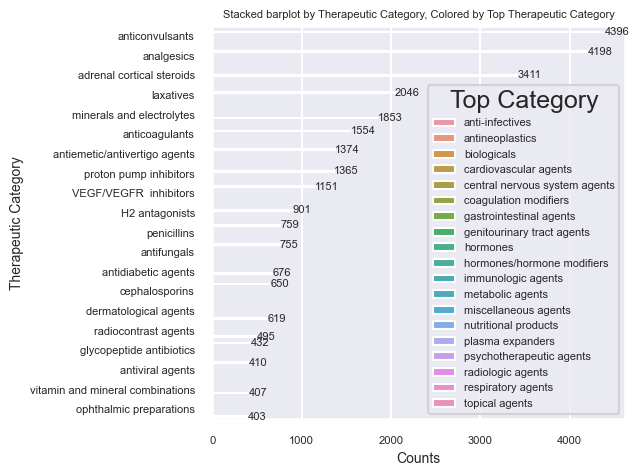

In [23]:
# Visualization pipeline (preprocess %>% save_ttc)
save_tc_and_ttc_countplot(retain_confirmed_admin(preprocess_meds_df()))

Preprocessing data...
Number of rows: 45757	Number of Uniques: 551
Preprocessing data done.

Filtering out unconfirmed administration...
Number of Unconfirmed rows: 45757	Number of Unique Unconfirmed: 551
Number of Confirmed rows: 37241	Number of Unique Confirmed: 428
Filtering out unconfirmed administration done.



C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\suns2\AppData\Local\miniconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


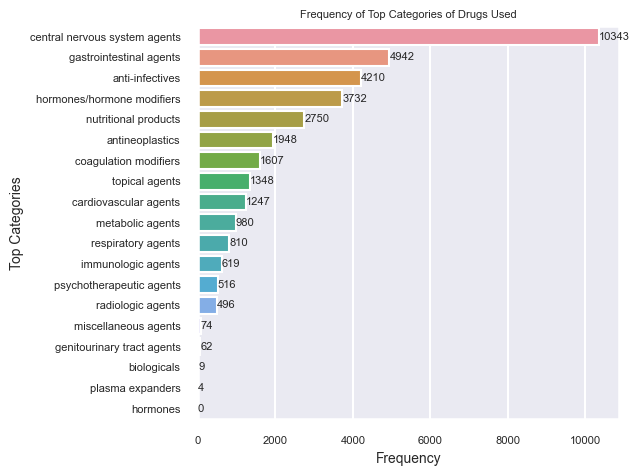

In [24]:
# Visualization pipeline (preprocess %>% save_tc_and_ttc)
save_ttc_countplot(retain_confirmed_admin(preprocess_meds_df()))

In [37]:
def obtain_rxcui_from_drugs(drugs_df: pd.DataFrame, verbose: bool=False,
                            supremum_path: str = './results/supremum_words_included.txt'):
    '''Request RxCUIs for drugs, as standardization.
        Exits pipe to avoid calling API idempotently (idempotently generally).'''

    print('Obtaining RxCUIs from drugs...')

    # Select and copy `Order_Name` from main DataFrame.
    drugs = drugs_df[['Order_Name']]

    # For the one-hot encoding, cast to category type
    drugs = drugs.astype('category')

    # One-hot encode the drug administration (independent) variable (spread out over multiple columns)
    print('One-hot encoding...')
    # Fit and transform the data
    encoded_drugs = OneHotEncoder().fit_transform(pd.DataFrame(drugs))
    print('One-hot encoding done.\n')

    # For human-readability, remove of 'Order_Name=' prefix which was added by `OneHotEncoder`. Will be prefixed back later.
    encoded_drugs = encoded_drugs.rename(
        columns={col: col.replace('Order_Name=', '') for col in encoded_drugs.columns})

    with open('./results/drugs_in_onehot.json', 'w') as file:
        json.dump(encoded_drugs.columns.tolist(), file)

    # Condense (by vector-summing the rows with same index) the duplicate `Subject` rows (each representing one administration/appointment)
    dedup_drugs = encoded_drugs.groupby(encoded_drugs.index).sum()
    # Replace non-zero values so that it's a ONE-hot encoding again
    dedup_drugs[dedup_drugs != 0.0] = 1.0

    print(dedup_drugs.info())

    def legalize_string_4_rxnorm(string: str) -> str:
        '''The below text processing is RxNorm-specific.'''

        # Rudimentary text processing (spacing out "/"-divided names),
        # e.g. "Calcium Carbonate/Vitamin D" --> "Calcium Carbonate / Vitamin D"
        string = (string.replace('/', ' / ')
        # Rudimentary text processing (spacing out "-"-divided names),
        # e.g. "amlodipine-valsartan tablet" --> "amlodipine - valsartan tablet"
                        .replace('-', ' - ')
        # RxNorm doesn't accept commas (see: https://ndclist.com/rxnorm-lookup)
                        .replace(',', ''))
        # RxNorm doesn't accept parentheses (see: https://ndclist.com/rxnorm-lookup), so move parenthesized word(s) (sometimes entity names) to the front of the string
        # TK why isn't this working??
        string = re.sub(r'(.*)\(([a-z\sA-Z]{2,})\)(.*)', r'\2 \1 \3', string)
        # RxNorm doesn't accept parentheses
        string = string.replace(r'\(|\)|\([^\s]*\)', '')  # TK why isn't this working??
        # Replace multiple spaces with single spaces
        string = re.sub(r'\s{2,}', ' ', string)
        # Remove trailing spaces
        string = re.sub(r'\s+$', '', string)
        return string
    # Legalize column names in preparation for converting to RxCUIs
    dedup_drugs = dedup_drugs.rename(
        columns={col: legalize_string_4_rxnorm(col) for col in dedup_drugs.columns})

    # Stripping (from left) extraneous text to aid (a redo of) RxNorm normalization
    dedup_drugs = dedup_drugs.rename(
        columns={col: col.replace('iv pca ', '').replace('hafine ', '')
                 .replace('sar ', '').replace('celluvisc ', '')
                 .replace('prohance ', '').replace('refresh plus ', '')
                 .replace('novel ', '').replace('medoral ', '')
                 .replace('sc pca ', '') for col in dedup_drugs.columns})

    dedup_drugs = dedup_drugs.rename(
        columns={col: 'influenza virus vaccine injection' for col in dedup_drugs.columns if 'influenza virus vaccine injection' in col})

    # Unifying errant drug names (by finding synonyms which have RxCUIs associated with them)
    synonymizing = {
        '$$$rhg zd6474 100 mg tablet': '$$$vandetanib 100 mg tablet',
        'anti - lag - 3 gbm infusion': 'relatlimab',
        'gw572016': 'lapatinib ditosylate',
        'neutra - phos': 'potassium sodium phosphate'
    }
    dedup_drugs = dedup_drugs.rename(columns=synonymizing)

    # Unifying errant drug names (by finding common, generic (i.e. non-dosed, non-dose-formed) names to which to unify)
    genericizing = {
        '$$$trc105 infusion 7 mg / ml': '$$$trc105 infusion',

        'carbo combo enzastaurin (125 mg tablet)': 'carbo combo enzastaurin 125 mg tablet',
        'carbo combo enzastaurin (125 mg / tablet)': 'carbo combo enzastaurin 125 mg tablet',

        'multivitamin chewable tablet': 'multivitamin tablet',
        'multivitamin with minerals tablet': 'multivitamin tablet',

        'ly317615 rhg 100 mg tablet': 'enzastaurin rhg 100 mg tablet',
        'ly317615 rhg 200 mg tablet': 'enzastaurin rhg 200 mg tablet',

        'enzastaurin armg (125 mg per tablet)': 'enzastaurin armg 125 mg tablet'
    }
    dedup_drugs = dedup_drugs.rename(columns=genericizing)

    # Load previously obtained supremum (for efficiency when normalizing repeatedly)
    supremum = 100
    min_tokens = []
    if os.path.getsize(supremum_path) >= 2 * len(dedup_drugs.columns):
        # Open the CSV file for reading
        with open(supremum_path, 'r') as file:
            set_string = file.read()
            if set_string.endswith(','):
                set_string = set_string[:-1]
            min_tokens = json.loads('[' + set_string + ']')
        supremum = max(min_tokens)
    # Empty the 'supremum_words_included.txt' file
    with open(supremum_path, 'w'):
        pass

    def normalize_drug_naively(drug_name: str) -> str:
        '''Get drug RxCUIs via raw-inputted (no non-RxNorm NER) RxNorm.'''

        # Check whether the order had been marked
        marked_4_interest = drug_name.startswith('$$$')
        # Unmark temporarily
        if marked_4_interest:
            drug_name = drug_name.replace('$$$', '')

        # Rudimentarily tokenize the drug name
        split_order = drug_name.split(' ')

        # Default result (in case the drug name not recognized, thus RxCUI not assigned)
        result = drug_name

        # If full name doesn't work, repeatedly try to search smaller and smaller substrings (prioritizing front of string)
        for n_words_included in range(min(supremum, len(split_order)), 0, -1):
            search_string = ' '.join(split_order[:n_words_included-1])
            if verbose:
                print(f'Querying for {search_string} with {n_words_included} words included...')
            drug_rxcui = query_findRxcuiByString(search_string)
            if drug_rxcui != '' and drug_rxcui.isdigit():
                result = str(drug_rxcui)
                with open('./results/supremum_words_included.txt', 'a') as file:
                    file.write(str(n_words_included) + ',')
                break

        # Re-mark RxCUI obtained from query
        return ('$$$' if marked_4_interest else '') + result

    # Normalize the drug names
    normalized_drugs = dedup_drugs.rename(
        columns={col: normalize_drug_naively(col) for col in dedup_drugs.columns})

    # Evaluate the above NER method by calculating the percentage of drug names it recognized (possibly false-positively).
    total, positive = len(normalized_drugs.columns), len([col for col in normalized_drugs.columns if col.replace('$$$', '').isdigit()])
    with open('./results/percentage_recognized.txt', 'w') as file:
        line = f'Normalized Drugs:\n\tRecognized: {positive}\n\tTotal: {total}\n\tPercent recognized: {positive / total * 100:.2f}%\n'
        print(line)
        file.write(line)

    # Prettify un-normalized drug names
    normalized_drugs = normalized_drugs.rename(
        columns={col: col.replace(' - ', '-') for col in normalized_drugs.columns})

    # Examine and print the index, before and after normalization
    after_before = {}
    for (rxcui, name) in zip(normalized_drugs.columns, dedup_drugs.columns):
        print(f'{rxcui}: {name}')
        after_before.update({rxcui:name})
    # Serialize the before-and-after (note: informally, since dicts are unique in their keys)
    with open('./results/after_&_before_normalization.json', 'w') as file:
        json.dump(after_before, file)

    # Condense (by vector-summing the columns with same column names (RxCUI)) the duplicate columns to complete the normalization
    normalized_drugs = normalized_drugs.groupby(normalized_drugs.columns, axis='columns').sum()
    print(f'Number of drug features before normalization:\t{len(dedup_drugs.columns)}\nNumber of drug features after normalization: \t{len(normalized_drugs.columns)}')
    # Replace non-zero values so that it's a ONE-hot encoding again
    normalized_drugs[normalized_drugs != 0.0] = 1.0

    # For human-readability, restore 'Order_Name=' prefix which was added by `OneHotEncoder` and which was removed.
    normalized_drugs = normalized_drugs.rename(
        columns={col: 'Order_Name=' + col for col in normalized_drugs.columns})

    # Serialize (so we don't have to repeatedly use the API) the DataFrames
    normalized_drugs.to_pickle('./results/explanatory_drugs.pkl')



In [51]:
(preprocess_meds_df().pipe(despace_col_names)
                     .pipe(retain_confirmed_admin)
                     .pipe(retain_post_GBM_orders)
                     .pipe(clean_order_names)
                     .pipe(indicate_investigational_orders)
                     .pipe(obtain_rxcui_from_drugs))

Preprocessing data...
Number of rows: 45757	Number of Uniques: 551
Preprocessing data done.

Filtering out unconfirmed administration...
Number of Unconfirmed rows: 45757	Number of Unique Unconfirmed: 551
Number of Confirmed rows: 37241	Number of Unique Confirmed: 428
Filtering out unconfirmed administration done.

Filtering out administrations before GBM diagnosis...
<class 'pandas.core.frame.DataFrame'>
Index: 1025 entries, 1799-Subject-00000017 to 1799-Subject-00001614
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Date_of_death             852 non-null    datetime64[ns]
 1   Date_of_Diagnosis         1025 non-null   datetime64[ns]
 2   Age_at_Time_of_Diagnosis  1025 non-null   Int64         
dtypes: Int64(1), datetime64[ns](2)
memory usage: 33.0+ KB
None
Size of the intersection of med and dx indices:	403
Number of GBM Dx rows: 1025		Number of Unique GBM Dx: 1025
Number

Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to 

Request succeeded.
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Request succeeded.
Making request to RxNorm..

Request succeeded.
Making request to RxNorm...
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Request

Making request to RxNorm...
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Making request to

Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Request succeeded.
Making request to RxNorm.

Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Request failed with status code: 400
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Making request to RxNorm...
Making request to

Request succeeded.
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Request succeeded.
Making r

Request succeeded.
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Request 

Making request to RxNorm...
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Request failed with status code: 400
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to R

Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Request succeeded.
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making request to RxNorm...
Making re

C:\Users\suns2\AppData\Local\Temp\ipykernel_29172\473050677.py:166: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  normalized_drugs = normalized_drugs.groupby(normalized_drugs.columns, axis='columns').sum()


In [38]:
def obtain_top_n_orders(confirmed_df: pd.DataFrame, n_included: int=100):
    '''Getting top-n most used medications naively via `Order_Name` (free text). Not intended to be part of any longstanding pipeline.'''
    # Count up most ordered medications
    order_counts_confirmed_df = confirmed_df.groupby('Order_Name').size().reset_index(name='order_counts')
    # Sort the counts
    order_counts_confirmed_df = order_counts_confirmed_df.sort_values(by='order_counts', ascending=False)
    # Save the results
    order_counts_confirmed_df.head(n_included).to_csv('./results/output_orders.csv', index=False)

In [39]:
def obtain_top_n_ingreds(confirmed_df: pd.DataFrame, n_included: int=100):
    '''Getting top-n most used medications less naively via `drug_ingredients` (CSV). Not intended to be part of any longstanding pipeline.'''
    # Split CSV into separate columns, similar to MS Excel's 'Text to Columns' method
    split_ingredients_cols = confirmed_df['drug_ingredients'].str.split(', ', expand=True)
    # Concatenate said columns into a (stripped) DataFrame containing only the `Subject` column
    split_ingredients_df = pd.concat([confirmed_df['Subject'], split_ingredients_cols], axis='columns')
    # Melt said DataFrame so that each ingredient occupies a different row
    melted_split_ingredients_df = pd.melt(split_ingredients_df, id_vars=['Subject'], value_name='split_ingredients')
    # Count up most used ingredients
    counts_melted_split_ingredients_df = melted_split_ingredients_df.groupby('split_ingredients').size().reset_index(name='ingredient_counts')
    # Sort the counts
    counts_melted_split_ingredients_df = counts_melted_split_ingredients_df.sort_values(by='ingredient_counts', ascending=False)
    # Save the results
    counts_melted_split_ingredients_df.head(n_included).to_csv('./results/output_ingredients.csv', index=False)


In [19]:
# obtain_top_n_ingreds(retain_confirmed_admin(despace_col_names(preprocess_meds_df())))  - failed


In [40]:
# obtain_top_n_ingreds(retain_confirmed_admin(despace_col_names(preprocess_meds_df())))

In [26]:
#despace_col_names(preprocess_meds_df())
#retain_confirmed_admin(despace_col_names(preprocess_meds_df()))


Preprocessing data...
Number of rows: 45757	Number of Uniques: 551
Preprocessing data done.



TypeError: despace_col_names() missing 1 required positional argument: 'formatted_df'

In [42]:
(preprocess_meds_df().pipe(despace_col_names)
                     .pipe(retain_confirmed_admin)
                     .pipe(retain_post_GBM_orders)
                     .pipe(clean_order_names)
                     .pipe(obtain_top_n_orders))
                     #.pipe(obtain_top_n_ingreds))


Preprocessing data...
Number of rows: 45757	Number of Uniques: 551
Preprocessing data done.

Filtering out unconfirmed administration...
Number of Unconfirmed rows: 45757	Number of Unique Unconfirmed: 551
Number of Confirmed rows: 37241	Number of Unique Confirmed: 428
Filtering out unconfirmed administration done.

Filtering out administrations before GBM diagnosis...
<class 'pandas.core.frame.DataFrame'>
Index: 1025 entries, 1799-Subject-00000017 to 1799-Subject-00001614
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Date_of_death             852 non-null    datetime64[ns]
 1   Date_of_Diagnosis         1025 non-null   datetime64[ns]
 2   Age_at_Time_of_Diagnosis  1025 non-null   Int64         
dtypes: Int64(1), datetime64[ns](2)
memory usage: 33.0+ KB
None
Size of the intersection of med and dx indices:	403
Number of GBM Dx rows: 1025		Number of Unique GBM Dx: 1025
Number

In [91]:
df = (preprocess_meds_df().pipe(despace_col_names)
                     .pipe(retain_confirmed_admin)
                     .pipe(retain_post_GBM_orders)
                     .pipe(clean_order_names))
#                     .pipe(obtain_top_n_ingreds))


Preprocessing data...
Number of rows: 45757	Number of Uniques: 551
Preprocessing data done.

Filtering out unconfirmed administration...
Number of Unconfirmed rows: 45757	Number of Unique Unconfirmed: 551
Number of Confirmed rows: 37241	Number of Unique Confirmed: 428
Filtering out unconfirmed administration done.

Filtering out administrations before GBM diagnosis...
<class 'pandas.core.frame.DataFrame'>
Index: 1025 entries, 1799-Subject-00000017 to 1799-Subject-00001614
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Date_of_death             852 non-null    datetime64[ns]
 1   Date_of_Diagnosis         1025 non-null   datetime64[ns]
 2   Age_at_Time_of_Diagnosis  1025 non-null   Int64         
dtypes: Int64(1), datetime64[ns](2)
memory usage: 33.0+ KB
None
Size of the intersection of med and dx indices:	403
Number of GBM Dx rows: 1025		Number of Unique GBM Dx: 1025
Number

In [83]:
split_ingredients_cols = df['drug_ingredients'].str.split(', ', expand=True)

In [128]:
split_ingredients_df = pd.concat([df.index, split_ingredients_cols], axis='columns')

TypeError: cannot concatenate object of type '<class 'pandas.core.indexes.base.Index'>'; only Series and DataFrame objs are valid

In [71]:
melted_split_ingredients_df = pd.melt(split_ingredients_cols, id_vars=['Subject'], value_name='split_ingredients')

KeyError: "The following 'id_vars' are not present in the DataFrame: ['Subject']"

In [86]:
df['Subject']

KeyError: 'Subject'

In [127]:
df.iloc[0]

Order_Name                                               bevacizumab infusion
drug_type                                                           Formulary
drug_ingredients                                                  Bevacizumab
Category                     Antineoplastic Antiangiogenesis Agent, Anti-V...
top_therapeutic_category                                      antineoplastics
therapeutic_category                 antineoplastics | VEGF/VEGFR  inhibitors
Order_Note                                                                NaN
Event_Primary_Date_Time                                   2007-07-19 09:00:00
Order_Status                                                              NaN
Take_Home_Flag                                                              0
Order_Frequency                                                 one time dose
Order_Dose                                                            627 mg 
Order__Route                                          by intrave